#### <font color=#1CADE4>Análise de Dados - Vigilância da Síndrome Gripal (SG) de casos leves e moderados suspeitos de covid-19.</font>

Os dados são oriundos do sistema e-SUS Notifica, que foi desenvolvido para registro de casos de Síndrome Gripal suspeitos de covid-19, e contém dados referentes ao local de residência do paciente (variáveis: estado, município), independentemente de terem sido notificados em outro estado ou município, resultados de exames laboratoriais, além de dados demográficos e clínicos epidemiológicos.

Trabalharemos com os dados do estado Tocantins

##### <font color=#1CADE4>Importação das Bibliotecas</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### <font color=#1CADE4>Leitura dos Dados</font>

<font color=#1CADE4>Base de Dados</font>

De modo a hospedar os dados no repositório do GitHub, foi necessário dividi-lo em dois arquivos.  
No carregamento utilizamos da função <kbd><font color=#1CADE4>concat()</kbd></font> da biblioteca pandas para unificar os DataFrames em um único.  
Também utilizamos o parâmetro <kbd><font color=#1CADE4>usecols=</kbd></font> na função <kbd><font color=#1CADE4>read_scv()</kbd></font> para carregar apenas as colunas necerssárias a execussão.

In [2]:
colunas_desejadas = ["profissionalSaude", "idade", "sexo", "racaCor", "codigoContemComunidadeTradicional",
                    "municipioIBGE", "municipioNotificacaoIBGE", "sintomas", "dataInicioSintomas", "codigoRecebeuVacina",
                    "codigoDosesVacina", "dataPrimeiraDose", "dataSegundaDose", "totalTestesRealizados", 'classificacaoFinal']

dados_parte1 = pd.read_csv('https://raw.githubusercontent.com/devurbano/projeto_tp/main/dados_TO_01.csv', usecols=colunas_desejadas)
dados_parte2 = pd.read_csv('https://raw.githubusercontent.com/devurbano/projeto_tp/main/dados_TO_02.csv', usecols=colunas_desejadas)

dados = pd.DataFrame()
dados = pd.concat([dados_parte1, dados_parte2], axis=0)

C:\Users\FabianoRodrigues\AppData\Local\Temp\ipykernel_3380\423465793.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dados_parte1 = pd.read_csv('https://raw.githubusercontent.com/devurbano/projeto_tp/main/dados_TO_01.csv', usecols=colunas_desejadas)


<font color=#1CADE4>Exibição de Amostra da Base de Dados SG </font>

In [3]:
dados.head(3)

,sintomas,profissionalSaude,racaCor,sexo,municipioIBGE,municipioNotificacaoIBGE,classificacaoFinal,codigoRecebeuVacina,codigoContemComunidadeTradicional,codigoDosesVacina,totalTestesRealizados,dataInicioSintomas,dataPrimeiraDose,dataSegundaDose,idade
0,"Tosse, Febre, Dispneia, Coriza",Não,Preta,Masculino,1709500,1709500.0,Descartado,NaN,2.0,NaN,1,2023-11-04,NaN,NaN,0.0
1,"Tosse, Febre, Dor de Garganta, Outros",Não,Amarela,Feminino,1702109,1702109.0,Confirmado Laboratorial,1.0,2.0,"1,2,3",1,2022-11-27,2021-06-17,2021-09-17,21.0
2,Assintomático,Não,Parda,Masculino,1720259,1720259.0,Confirmado Laboratorial,1.0,2.0,"1,2",1,NaN,2021-09-16,2021-10-28,24.0


<font color=#1CADE4>Base de Dados de Municípios Brasileiros do IBGE</font>

De maneira a facilitar a junção dos dados, a coluna <kbd><font color=#1CADE4>municipio-id</kbd></font> foi renomeada para <kbd><font color=#1CADE4>municipioIBGE</kbd></font> utilizando a função <kbd><font color=#1CADE4>rename()</kbd></font> da biblioteca pandas.

In [4]:
dados_municipio = pd.read_json('https://raw.githubusercontent.com/devurbano/projeto_tp/main/servico_dados_ibge_municipio.json')
dados_municipio.rename(columns={'municipio-id': 'municipioIBGE'}, inplace=True)

<font color=#1CADE4>Exibição de Amostra da Base de Dados Municípios IBGE </font>

In [5]:
dados_municipio.head(3)

,municipioIBGE,municipio-nome,microrregiao-id,microrregiao-nome,mesorregiao-id,mesorregiao-nome,regiao-imediata-id,regiao-imediata-nome,regiao-intermediaria-id,regiao-intermediaria-nome,UF-id,UF-sigla,UF-nome,regiao-id,regiao-sigla,regiao-nome
0,1100015,Alta Floresta D'Oeste,11006,Cacoal,1102,Leste Rondoniense,110005,Cacoal,1102,Ji-Paraná,11,RO,Rondônia,1,N,Norte
1,1100023,Ariquemes,11003,Ariquemes,1102,Leste Rondoniense,110002,Ariquemes,1101,Porto Velho,11,RO,Rondônia,1,N,Norte
2,1100031,Cabixi,11008,Colorado do Oeste,1102,Leste Rondoniense,110006,Vilhena,1102,Ji-Paraná,11,RO,Rondônia,1,N,Norte


##### <font color=#1CADE4>Cruzando as Bases de Dados</font>

Em uma tentative prévia de executar o merge, identificamos que existem dados diferntes de numéricos na coluna <kbd><font color=#1CADE4>municipioIBGE</kbd></font> que armazena o código de minicípios em 7 digitos, sendo necessário tratamentos adicionais.

In [6]:
dados[['municipioIBGE', 'municipioNotificacaoIBGE']].dtypes

municipioIBGE                object
municipioNotificacaoIBGE    float64
dtype: object

O erro apresentou a presença de strings nos dados. Efetuamos então uma pesquisa com <kbd><font color=#1CADE4>REGEX</kbd></font> para localizar as linhas.

In [7]:
dados[dados['municipioIBGE'].str.contains('^[a-zA-Z]*$', case=False, na=False)]

,sintomas,profissionalSaude,racaCor,sexo,municipioIBGE,municipioNotificacaoIBGE,classificacaoFinal,codigoRecebeuVacina,codigoContemComunidadeTradicional,codigoDosesVacina,totalTestesRealizados,dataInicioSintomas,dataPrimeiraDose,dataSegundaDose,idade
806,Coriza,Não,Parda,Masculino,TO,NaN,Confirmado Clínico-Epidemiológico,NaN,NaN,NaN,1,2021-01-20,NaN,NaN,NaN
856,Outros,Sim,Parda,Feminino,GO,NaN,Confirmado Laboratorial,NaN,NaN,NaN,2,2020-12-25,NaN,NaN,46.0
17945,"Dor de Garganta, Tosse, Febre",Não,Parda,Masculino,TO,NaN,Descartado,NaN,NaN,NaN,1,2021-02-01,NaN,NaN,26.0
18017,"Tosse, Outros, Dor de Cabeça",Não,Parda,Feminino,TO,NaN,Descartado,NaN,NaN,NaN,1,2021-01-20,NaN,NaN,28.0
18047,"Febre, Dor de Cabeça",Não,Branca,Masculino,TO,NaN,Confirmado Clínico-Epidemiológico,NaN,NaN,NaN,1,2021-01-23,NaN,NaN,39.0
18055,"Febre, Tosse",Não,Preta,Masculino,TO,NaN,Confirmado Laboratorial,NaN,NaN,NaN,1,2021-01-24,NaN,NaN,31.0
18233,Assintomático,Não,Parda,Feminino,TO,NaN,Descartado,NaN,NaN,NaN,1,2021-02-02,NaN,NaN,39.0
18305,Assintomático,Não,Parda,Feminino,TO,NaN,Descartado,NaN,NaN,NaN,1,2021-02-03,NaN,NaN,NaN
18343,Outros,Não,Parda,Feminino,TO,NaN,Confirmado Clínico-Epidemiológico,NaN,NaN,NaN,1,2021-01-23,NaN,NaN,52.0
18423,"Dispneia, Febre, Tosse, Dor de Garganta",Não,Parda,Feminino,TO,NaN,Descartado,NaN,NaN,NaN,1,2020-12-07,NaN,NaN,51.0


Sendo uma quantidade inferior 0,0003% da amostra, optamos por excluir as linhas da base de dados.

In [8]:
dados = dados[~dados['municipioIBGE'].str.contains('^[a-zA-Z]*$', case=False, na=False)]

Aproveitamos para efetuar um consulta e checar a existência de valores <kbd><font color=#1CADE4>NaN</kbd></font> na coluna.

In [9]:
dados['municipioIBGE'].isna().sum()

562

Como os dados da coluna estava atribuídos como <kbd><font color=#1CADE4>object</kbd></font>, utilizamos o metodo <kbd><font color=#1CADE4>astype()</kbd></font> para converter para inteiros, e preenchemos os valores <kbd><font color=#1CADE4>NaN</kbd></font> encontrados com o digito <kbd><font color=#1CADE4>0</kbd></font> utilizando o método <kbd><font color=#1CADE4>fillna()</kbd></font>.

In [10]:
#dados['municipioIBGE'] = dados['municipioIBGE'].fillna(0)
dados['municipioIBGE'] = dados['municipioIBGE'].astype(float).astype('Int64').fillna(0)

Verificamos se ainda existem valores nulos na coluna com o método <kbd><font color=#1CADE4>isna()</kbd></font> e o método <kbd><font color=#1CADE4>any()</kbd></font>.

In [11]:
dados['municipioIBGE'].isna().any()

False

E verificamos se a coerção de tipo da coluna <kbd><font color=#1CADE4>municipioIBE</kbd></font> foi realizada.

In [12]:
dados['municipioIBGE'].dtype

Int64Dtype()

De acordo com um <kbd><font color=RED>Warning</kbd></font> na biblioteca da função <kbd><font color=#1CADE4>merge()</kbd></font>, existe a possibilidade de ocorrências estranhas nos dados após o cruzamento das tabela, então optamos por utilizar a função <kbd><font color=#1CADE4>shape</kbd></font> para acompanhar a quantidade de linhas do DataFrame antes e depois da junção das tabelas.

In [13]:
dados.shape

(63852, 15)

Após o tratamento de tipo utilizamos a função <kbd><font color=#1CADE4>merge()</kbd></font> para trazer as colunas <kbd><font color=#1CADE4>UF-sigla, UF-nome e municipio-nome</kbd></font> da BAse de Dados de Municíos do IBGE para nossos dados de Sindrome Gripal.

In [14]:
dados = dados.merge(dados_municipio[['municipioIBGE','UF-sigla','UF-nome','municipio-nome']], on='municipioIBGE' ,how='left')
dados.head(3)

,sintomas,profissionalSaude,racaCor,sexo,municipioIBGE,municipioNotificacaoIBGE,classificacaoFinal,codigoRecebeuVacina,codigoContemComunidadeTradicional,codigoDosesVacina,totalTestesRealizados,dataInicioSintomas,dataPrimeiraDose,dataSegundaDose,idade,UF-sigla,UF-nome,municipio-nome
0,"Tosse, Febre, Dispneia, Coriza",Não,Preta,Masculino,1709500,1709500.0,Descartado,NaN,2.0,NaN,1,2023-11-04,NaN,NaN,0.0,TO,Tocantins,Gurupi
1,"Tosse, Febre, Dor de Garganta, Outros",Não,Amarela,Feminino,1702109,1702109.0,Confirmado Laboratorial,1.0,2.0,"1,2,3",1,2022-11-27,2021-06-17,2021-09-17,21.0,TO,Tocantins,Araguaína
2,Assintomático,Não,Parda,Masculino,1720259,1720259.0,Confirmado Laboratorial,1.0,2.0,"1,2",1,NaN,2021-09-16,2021-10-28,24.0,TO,Tocantins,São Salvador do Tocantins


Estas colunas estão relacionadas ao municípi de domicilio de cada paciente, e como faremos um novo <kbd><font color=#1CADE4>merge()</kbd></font> para criar uma coluna de Municipio de Notificação do diagnóstico, utilizamo a função <kbd><font color=#1CADE4>rename()</kbd></font> para padronizar as informações conforme a coluna base. 

In [15]:
dados = dados.rename(columns={'municipio-nome': 'nomemunicipioIBGE'})
dados = dados.rename(columns={'UF-sigla': 'ufIBGE'})
dados = dados.rename(columns={'UF-nome': 'nomeufIBGE'})

Para facilitar, e minimizar a ocorrência de erros, para realizar a segunda junção da base de sindrome gripal com a base de municipios do IBGE, renomeamos a coluna de identificação da base de ddados do IBGE para parear com a coluna <kbd><font color=#1CADE4>municipioNotificacaoIBGE</kbd></font> que contém o código do município onde o paciente foi atendido.

In [16]:
dados_municipio.rename(columns={'municipioIBGE': 'municipioNotificacaoIBGE'}, inplace=True)

Novamente efetuamos o cruzamento dos dados utilizando a função <kbd><font color=#1CADE4>merge()</kbd></font>.

In [17]:
dados = dados.merge(dados_municipio[['municipioNotificacaoIBGE','municipio-nome']], on='municipioNotificacaoIBGE' , how='left')
dados.head(3)

,sintomas,profissionalSaude,racaCor,sexo,municipioIBGE,municipioNotificacaoIBGE,classificacaoFinal,codigoRecebeuVacina,codigoContemComunidadeTradicional,codigoDosesVacina,totalTestesRealizados,dataInicioSintomas,dataPrimeiraDose,dataSegundaDose,idade,ufIBGE,nomeufIBGE,nomemunicipioIBGE,municipio-nome
0,"Tosse, Febre, Dispneia, Coriza",Não,Preta,Masculino,1709500,1709500.0,Descartado,NaN,2.0,NaN,1,2023-11-04,NaN,NaN,0.0,TO,Tocantins,Gurupi,Gurupi
1,"Tosse, Febre, Dor de Garganta, Outros",Não,Amarela,Feminino,1702109,1702109.0,Confirmado Laboratorial,1.0,2.0,"1,2,3",1,2022-11-27,2021-06-17,2021-09-17,21.0,TO,Tocantins,Araguaína,Araguaína
2,Assintomático,Não,Parda,Masculino,1720259,1720259.0,Confirmado Laboratorial,1.0,2.0,"1,2",1,NaN,2021-09-16,2021-10-28,24.0,TO,Tocantins,São Salvador do Tocantins,São Salvador do Tocantins


Renomeamos a novca coluna para parear com a coluna que contém o código do município.

In [18]:
dados.rename(columns={'municipio-nome': 'nomemunicipioNotificacao'}, inplace=True)

Verificamos novamente a quantidade de linhas para garantir que não houve duplicação de dados.

In [19]:
dados.shape

(63852, 19)

Agora, através de uma reatribuição, reorganizamos a ordem das colunas para facilitar a análise dos dados.

In [20]:
dados = dados[['sintomas','profissionalSaude', 'racaCor', 'sexo','idade', 'municipioIBGE', 'ufIBGE',
       'nomeufIBGE', 'nomemunicipioIBGE', 'municipioNotificacaoIBGE','nomemunicipioNotificacao',
       'codigoRecebeuVacina', 'codigoContemComunidadeTradicional',
       'codigoDosesVacina', 'totalTestesRealizados', 'classificacaoFinal','dataInicioSintomas',
       'dataPrimeiraDose', 'dataSegundaDose']]

In [21]:
dados.head()

,sintomas,profissionalSaude,racaCor,sexo,idade,municipioIBGE,ufIBGE,nomeufIBGE,nomemunicipioIBGE,municipioNotificacaoIBGE,nomemunicipioNotificacao,codigoRecebeuVacina,codigoContemComunidadeTradicional,codigoDosesVacina,totalTestesRealizados,classificacaoFinal,dataInicioSintomas,dataPrimeiraDose,dataSegundaDose
0,"Tosse, Febre, Dispneia, Coriza",Não,Preta,Masculino,0.0,1709500,TO,Tocantins,Gurupi,1709500.0,Gurupi,NaN,2.0,NaN,1,Descartado,2023-11-04,NaN,NaN
1,"Tosse, Febre, Dor de Garganta, Outros",Não,Amarela,Feminino,21.0,1702109,TO,Tocantins,Araguaína,1702109.0,Araguaína,1.0,2.0,"1,2,3",1,Confirmado Laboratorial,2022-11-27,2021-06-17,2021-09-17
2,Assintomático,Não,Parda,Masculino,24.0,1720259,TO,Tocantins,São Salvador do Tocantins,1720259.0,São Salvador do Tocantins,1.0,2.0,"1,2",1,Confirmado Laboratorial,NaN,2021-09-16,2021-10-28
3,Assintomático,Não,Parda,Feminino,29.0,1702208,TO,Tocantins,Araguatins,1702208.0,Araguatins,1.0,2.0,"3,2,1",1,Descartado,NaN,2021-06-22,2021-11-29
4,"Tosse, Dor de Garganta",Não,Parda,Feminino,37.0,1709500,TO,Tocantins,Gurupi,1709500.0,Gurupi,NaN,2.0,NaN,1,Descartado,2023-10-30,NaN,NaN


Uma vez que a coluna sintomas apresenta composições distintas e muitas variações, optamos por verificar quais sintomas isolados foram relatados.  
Para isola-los utilizamos o método <kbd><font color=#1CADE4>join()</kbd></font> unificando todas as linhas em uma única string separada por virgulas, em seguida é aplicado o método <kbd><font color=#1CADE4>split()</kbd></font> para dividir a string em uma lista de sintomas.  
utilizamos uma função geradora para percorrer a lista com o método <kbd><font color=#1CADE4>strip()</kbd></font> eliminar os espaços vazios nas pontas de cada string.  
Por fim, utilizamos a função <kbd><font color=#1CADE4>set()</kbd></font> removendo dados duplicados, retornando enmtão apenas ums única string para cvada sintoma encontrado.


In [22]:
sintomas_unicos = set(sintoma.strip() for sintoma in ','.join(dados['sintomas']).split(','))
sintomas_unicos

{'Assintomático',
 'Coriza',
 'Dispneia',
 'Distúrbios Gustativos',
 'Distúrbios Olfativos',
 'Dor de Cabeça',
 'Dor de Garganta',
 'Febre',
 'Outros',
 'Tosse'}

Com os sintomas criamos uma <kbd><font color=#1CADE4>List comprehension</kbd></font> onde a classe List comprehension <kbd><font color=#1CADE4>enumerate</kbd></font> irá iterar na lista de sintomas únicos retornar o íncice e o sintoma para a função <kbd><font color=#1CADE4>insert()</kbd></font> criar uma nova coluna no Dataframe tendo como rótulo da coluna o sintoma.

In [23]:
posicao = 1
[dados.insert(posicao + i, sintoma, 0) for i, sintoma in enumerate(sintomas_unicos)]
dados.head(3)

,sintomas,Outros,Dor de Cabeça,Distúrbios Olfativos,Febre,Assintomático,Dor de Garganta,Dispneia,Tosse,Coriza,...,municipioNotificacaoIBGE,nomemunicipioNotificacao,codigoRecebeuVacina,codigoContemComunidadeTradicional,codigoDosesVacina,totalTestesRealizados,classificacaoFinal,dataInicioSintomas,dataPrimeiraDose,dataSegundaDose
0,"Tosse, Febre, Dispneia, Coriza",0,0,0,0,0,0,0,0,0,...,1709500.0,Gurupi,NaN,2.0,NaN,1,Descartado,2023-11-04,NaN,NaN
1,"Tosse, Febre, Dor de Garganta, Outros",0,0,0,0,0,0,0,0,0,...,1702109.0,Araguaína,1.0,2.0,"1,2,3",1,Confirmado Laboratorial,2022-11-27,2021-06-17,2021-09-17
2,Assintomático,0,0,0,0,0,0,0,0,0,...,1720259.0,São Salvador do Tocantins,1.0,2.0,"1,2",1,Confirmado Laboratorial,NaN,2021-09-16,2021-10-28


Uma vez criadas as colunas individuais de cada sintoma, criamos um laço que itera em cada elemento do set de sintomas e informa para uma função <kbd><font color=#1CADE4>lambda</kbd></font> procurar o sintoma na coluna <kbd><font color=#1CADE4>sintomas</kbd></font> e em caso posivito atribuir o digito <kbd><font color=#1CADE4>1</kbd></font> na coluna específica daquele sintoma. Contamos também o auxílio do método <kbd><font color=#1CADE4>apply()</kbd></font> que executou em cada uma das linhas do DataFrame.

In [24]:
for sintoma in sintomas_unicos:
    dados[sintoma] = dados['sintomas'].apply(lambda x: 1 if sintoma in x else 0)
dados.head(3)

,sintomas,Outros,Dor de Cabeça,Distúrbios Olfativos,Febre,Assintomático,Dor de Garganta,Dispneia,Tosse,Coriza,...,municipioNotificacaoIBGE,nomemunicipioNotificacao,codigoRecebeuVacina,codigoContemComunidadeTradicional,codigoDosesVacina,totalTestesRealizados,classificacaoFinal,dataInicioSintomas,dataPrimeiraDose,dataSegundaDose
0,"Tosse, Febre, Dispneia, Coriza",0,0,0,1,0,0,1,1,1,...,1709500.0,Gurupi,NaN,2.0,NaN,1,Descartado,2023-11-04,NaN,NaN
1,"Tosse, Febre, Dor de Garganta, Outros",1,0,0,1,0,1,0,1,0,...,1702109.0,Araguaína,1.0,2.0,"1,2,3",1,Confirmado Laboratorial,2022-11-27,2021-06-17,2021-09-17
2,Assintomático,0,0,0,0,1,0,0,0,0,...,1720259.0,São Salvador do Tocantins,1.0,2.0,"1,2",1,Confirmado Laboratorial,NaN,2021-09-16,2021-10-28


Uma vez mapeado os sintomas para colunas individuais, a coluna <kbd><font color=#1CADE4>sintoma</kbd></font> deixa de ser necessária, então eliminamos do nosso DataFrame utilizando a função <kbd><font color=#1CADE4>drop()</kbd></font> passando como parametros <kbd><font color=#1CADE4>columns=</kbd></font> para identificar a coluna e <kbd><font color=#1CADE4>inplace=True</kbd></font> para atribuir a exclusão permanentemente no DataFrame.

In [25]:
dados.drop(columns='sintomas',inplace=True)
dados.head(3)

,Outros,Dor de Cabeça,Distúrbios Olfativos,Febre,Assintomático,Dor de Garganta,Dispneia,Tosse,Coriza,Distúrbios Gustativos,...,municipioNotificacaoIBGE,nomemunicipioNotificacao,codigoRecebeuVacina,codigoContemComunidadeTradicional,codigoDosesVacina,totalTestesRealizados,classificacaoFinal,dataInicioSintomas,dataPrimeiraDose,dataSegundaDose
0,0,0,0,1,0,0,1,1,1,0,...,1709500.0,Gurupi,NaN,2.0,NaN,1,Descartado,2023-11-04,NaN,NaN
1,1,0,0,1,0,1,0,1,0,0,...,1702109.0,Araguaína,1.0,2.0,"1,2,3",1,Confirmado Laboratorial,2022-11-27,2021-06-17,2021-09-17
2,0,0,0,0,1,0,0,0,0,0,...,1720259.0,São Salvador do Tocantins,1.0,2.0,"1,2",1,Confirmado Laboratorial,NaN,2021-09-16,2021-10-28


##### <font color=#1CADE4>Análise dos Dados</font>

<kbd><font color=#1CADE4>1 - Relação entre raça/cor e sexo dos pacientes infectados</kbd></font>

In [26]:
dados.groupby(['racaCor', 'sexo']).size().reset_index(name='frequencia').sort_values('frequencia',ascending=False)

,racaCor,sexo,frequencia
8,Parda,Feminino,24146
9,Parda,Masculino,17025
2,Branca,Feminino,5760
0,Amarela,Feminino,3603
3,Branca,Masculino,3225
1,Amarela,Masculino,2542
4,Ignorado,Feminino,1727
5,Ignorado,Masculino,1564
10,Preta,Feminino,1561
11,Preta,Masculino,1245


<kbd><font color=#1CADE4>2  - Distribuição das idades dos pacientes infectados com grafico</kbd></font>

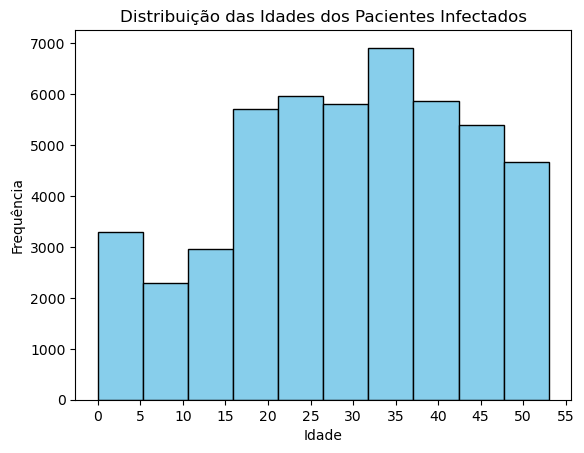

In [28]:
plt.hist(dados['idade'], color='skyblue', edgecolor='black')
plt.title('Distribuição das Idades dos Pacientes Infectados')
plt.xticks(range(0, 60, 5))
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()

<kbd><font color=#1CADE4>3</kbd></font>  - Qual percentual dos pacientes que não tiveram a idade resgistrada versos os que tiveram?

In [29]:
percentual_sem_idade = round((dados['idade'].isna().value_counts() / len(dados['idade'])) * 100, 2)
percentual_sem_idade

idade
False    76.57
True     23.43
Name: count, dtype: float64

<kbd><font color=#1CADE4>4 - Quais são os sintomas mais comuns?</kbd></font>

In [30]:
dados[list(sintomas_unicos)].sum().sort_values(ascending = False)

Tosse                    30040
Febre                    24302
Dor de Cabeça            24043
Coriza                   22777
Dor de Garganta          20374
Assintomático            15431
Outros                   12352
Dispneia                  4527
Distúrbios Gustativos     1722
Distúrbios Olfativos      1670
dtype: int64

<kbd><font color=#1CADE4>5 - Os 10 municipios com maior incidência de casos</kbd></font>

In [31]:
dados['classificacaoFinal'].unique()

array(['Descartado', 'Confirmado Laboratorial', nan,
       'Síndrome Gripal Não Especificada',
       'Confirmado Clínico-Epidemiológico',
       'Confirmado por Critério Clínico', 'Confirmado Clínico-Imagem'],
      dtype=object)

In [32]:
diagnostico = [ 'Confirmado Laboratorial',
       'Síndrome Gripal Não Especificada',
       'Confirmado Clínico-Epidemiológico',
       'Confirmado por Critério Clínico', 'Confirmado Clínico-Imagem']

filtro = dados[dados['classificacaoFinal'].isin(diagnostico)]

filtro['nomemunicipioNotificacao'].value_counts().head(10)

nomemunicipioNotificacao
Araguaína                2516
Gurupi                   1883
Paraíso do Tocantins     1673
Porto Nacional           1097
Taguatinga                486
Miracema do Tocantins     338
Tocantinópolis            192
Formoso do Araguaia       192
Dianópolis                190
Peixe                     177
Name: count, dtype: int64